# Assignment (part 1, Unsupervised)

In [166]:
import numpy as np # for linear algebra
import pandas as pd # for data processing, csv io
from matplotlib import pyplot as plt # data plots
import seaborn as sns # pretty data plots
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
sns.set()
import re
from sklearn.preprocessing import LabelEncoder # for label normalization
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import seaborn as sb # visualization
from mpl_toolkits.mplot3d import Axes3D # 3d plot
from termcolor import colored as cl # text customization

from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.cluster import KMeans # K-means algorithm

plt.rcParams['figure.figsize'] = (20, 10)
sb.set_style('whitegrid')

### Exploration of the dataset. Descriptive statistics. 

In [191]:
df_trans = pd.read_csv('Datasets/transactions.csv')
df_types = pd.read_csv('Datasets/types.csv', sep='delimiter')
df_codes = pd.read_csv('Datasets/codes.csv', sep='delimiter')
df_train = pd.read_csv('Datasets/train_set.csv')
df_test = pd.read_csv('Datasets/test_set.csv')

<ipython-input-191-23872f8e6f0d>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_types = pd.read_csv('Datasets/types.csv', sep='delimiter')
<ipython-input-191-23872f8e6f0d>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_codes = pd.read_csv('Datasets/codes.csv', sep='delimiter')


In [192]:
df_trans[['client_id', 'datetime', 'code', 'type', 'sum']] = df_trans['client_id;datetime;code;type;sum'].str.split(';', expand=True)
del df_trans['client_id;datetime;code;type;sum']

df_types[['type', 'type_description']] = df_types['type;type_description'].str.split(';', expand=True)
del df_types['type;type_description']

df_codes[['code', 'code_description']] = df_codes['code;code_description'].str.split(';', expand=True)
del df_codes['code;code_description']

df_train[['client_id', 'target']] = df_train['client_id;target'].str.split(';', expand=True)
del df_train['client_id;target']

In [193]:
join_codes = df_trans.merge(df_codes, on='code', how='left')

In [194]:
join_types = join_codes.merge(df_types, on='type', how='left')

In [195]:
df_joined = join_types.merge(df_train, on='client_id', how='left')

In [196]:
df_joined

,client_id,datetime,code,type,sum,code_description,type_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0
1,24567813,377 17:20:40,6011,7010,67377.47,Финансовые институты — снятие наличности автом...,Взнос наличных через АТМ (в своем тер.банке),NaN
2,21717441,55 13:38:47,6011,2010,-44918.32,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0
3,14331004,263 12:57:08,6011,2010,-3368873.66,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,NaN
4,85302434,151 10:34:12,4814,1030,-3368.87,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы,0
...,...,...,...,...,...,...,...,...
130034,15836839,147 11:50:53,5411,1010,-26344.59,"Бакалейные магазины, супермаркеты",Покупка. POS,NaN
130035,28369355,305 11:59:34,4829,2330,-24705.07,Денежные переводы,Списание с карты по операции “перевода с карты...,0
130036,40949707,398 21:13:58,5411,1110,-40353.72,"Бакалейные магазины, супермаркеты",Покупка. POS,1
130037,7174462,409 13:58:14,5411,1010,-25536.06,"Бакалейные магазины, супермаркеты",Покупка. POS,1


### Data Preparation
In the data preprocessing part, we will mainly look for

missings and fill them 

changing the necessary data types

In [197]:
print('Number of missing data:')
print(df_joined.isnull().sum())
df_joined.describe(include='all')

Number of missing data:
client_id               0
datetime                0
code                    0
type                    0
sum                     0
code_description        0
type_description       41
target              38213
dtype: int64


,client_id,datetime,code,type,sum,code_description,type_description,target
count,130039,130039,130039,130039,130039,130039,129998,91826
unique,8656,114770,175,67,27450,175,57,2
top,70780820,456 00:00:00,6011,1010,-2245.92,Финансовые институты — снятие наличности автом...,Покупка. POS,0
freq,2777,60,27917,30802,7487,27917,48450,46715


[Text(0.5, 1.0, 'Missing Data'),
 Text(0.5, 66.453125, 'Columns'),
 Text(156.5, 0.5, 'Data Points')]

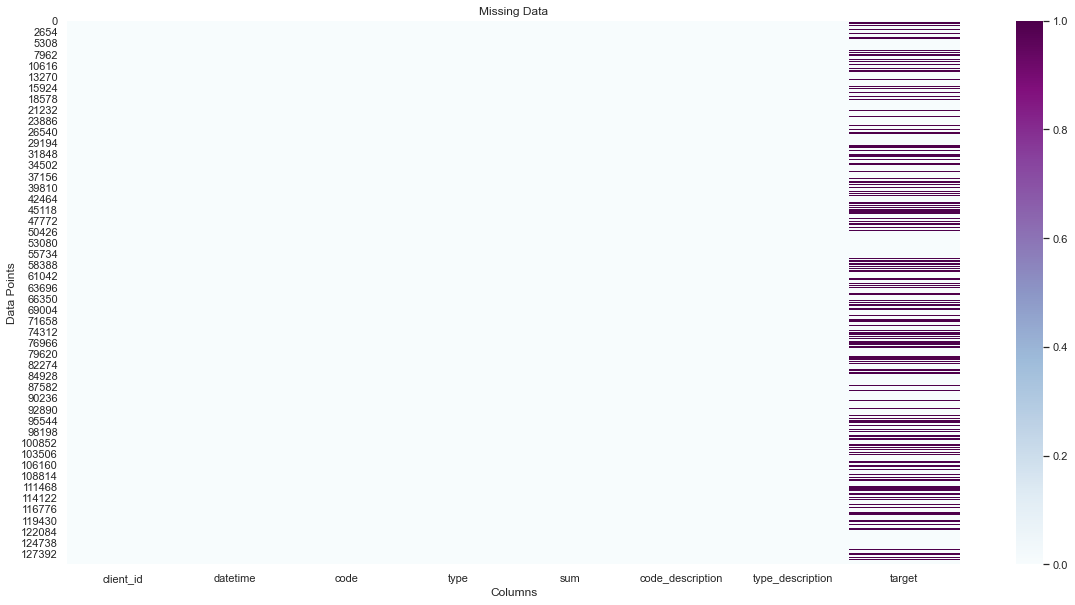

In [198]:
sns.heatmap(df_joined.isnull(), cmap="BuPu").set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

In [199]:
df=df_joined
df['target'] = pd.to_numeric(df['target'],errors = 'coerce')
df['sum'] = pd.to_numeric(df['sum'],errors = 'coerce')

In [200]:
df.groupby('target')[['sum']].median()

,sum
target,
0.0,-4731.70
1.0,-5682.17


In [201]:
df_joined.describe()

,sum,target
count,1.300390e+05,91826.000000
mean,-1.812909e+04,0.491266
std,5.584445e+05,0.499926
min,-4.150030e+07,0.000000
25%,-2.244916e+04,0.000000
50%,-5.502490e+03,0.000000
75%,-1.122960e+03,1.000000
max,6.737747e+07,1.000000


In [202]:
df_joined['type_description'].fillna(0, inplace=True)

In [203]:
# deleting all null values
df_joined = df_joined.dropna()
df_joined

,client_id,datetime,code,type,sum,code_description,type_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0
2,21717441,55 13:38:47,6011,2010,-44918.32,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0
4,85302434,151 10:34:12,4814,1030,-3368.87,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы,0.0
5,31421357,398 00:00:00,5411,1110,-1572.14,"Бакалейные магазины, супермаркеты",Покупка. POS,0.0
6,84826852,423 15:27:55,6010,7070,5654.99,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через Мобильный бан...,1.0
...,...,...,...,...,...,...,...,...
130033,57224158,380 13:52:15,6010,7030,7186.93,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через АТМ (в предел...,1.0
130035,28369355,305 11:59:34,4829,2330,-24705.07,Денежные переводы,Списание с карты по операции “перевода с карты...,0.0
130036,40949707,398 21:13:58,5411,1110,-40353.72,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0
130037,7174462,409 13:58:14,5411,1010,-25536.06,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0


In [204]:
df_joined.reset_index(drop=True, inplace=True)

In [205]:
print(df_joined.isnull().sum())

client_id           0
datetime            0
code                0
type                0
sum                 0
code_description    0
type_description    0
target              0
dtype: int64


In [206]:
df_joined.code.unique()

array(['6011', '4814', '5411', '6010', '5699', '5541', '4829', '5331',
       '5661', '8999', '5499', '3000', '9399', '5964', '7399', '5814',
       '7995', '5812', '5912', '5999', '5977', '5813', '4816', '6012',
       '5200', '5734', '7994', '7011', '5722', '8641', '5199', '4789',
       '5261', '7832', '4112', '8021', '5691', '5311', '5655', '4722',
       '5942', '5992', '5651', '5074', '4511', '5714', '5983', '8043',
       '5943', '4111', '5732', '7230', '6536', '5921', '4121', '5735',
       '8011', '5422', '5211', '5641', '5621', '7311', '7542', '5995',
       '4900', '4812', '4899', '5719', '5993', '5451', '5300', '5511',
       '5712', '8099', '5231', '6051', '5941', '5945', '5045', '5948',
       '7993', '5533', '7999', '5944', '5631', '5441', '742', '5251',
       '5399', '7997', '4215', '5947', '6300', '5599', '7538', '5013',
       '5946', '6513', '5309', '5681', '5811', '5967', '5713', '5976',
       '8062', '7299', '5542', '7922', '5931', '9222', '7372', '5192',
       

In [207]:
df_joined.type.unique()

array(['2010', '1030', '1110', '7070', '7030', '1010', '7010', '2371',
       '2011', '4071', '1100', '1200', '1310', '2370', '7071', '2440',
       '2330', '7020', '2110', '7021', '6110', '4051', '7031', '1210',
       '4010', '2340', '7011', '2331', '4110', '2210', '4090', '7074',
       '4011', '2320', '7014', '4210', '2020', '7034', '6200', '4041',
       '6010', '7075', '7015', '2460', '8100', '2021', '2456', '4097',
       '4031', '6100', '6210', '1410', '4200', '7035', '4020', '7024',
       '7040', '4500', '7041', '4061', '8145'], dtype=object)

In [209]:
df_joined['day'] = df_joined['datetime'].str.split(' ').apply(lambda x: int(x[0]))
df_joined['hour'] = df_joined['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[0]), 23))
df_joined['minute'] = df_joined['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[1]), 59))
df_joined['second'] = df_joined['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[2]), 59))

<ipython-input-209-0361d683e027>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined['day'] = df_joined['datetime'].str.split(' ').apply(lambda x: int(x[0]))
<ipython-input-209-0361d683e027>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined['hour'] = df_joined['datetime'].str.split(' ').apply(lambda x:  min(int(x[1].split(':')[0]), 23))
<ipython-input-209-0361d683e027>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [210]:
df_joined

,client_id,datetime,code,type,sum,code_description,type_description,target,day,hour,minute,second
0,96372458,421 06:33:15,6011,2010,-561478.94,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0,421,6,33,15
1,21717441,55 13:38:47,6011,2010,-44918.32,Финансовые институты — снятие наличности автом...,Выдача наличных в АТМ,0.0,55,13,38,47
2,85302434,151 10:34:12,4814,1030,-3368.87,"Звонки с использованием телефонов, считывающих...",Оплата услуги. Банкоматы,0.0,151,10,34,12
3,31421357,398 00:00:00,5411,1110,-1572.14,"Бакалейные магазины, супермаркеты",Покупка. POS,0.0,398,0,0,0
4,84826852,423 15:27:55,6010,7070,5654.99,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через Мобильный бан...,1.0,423,15,27,55
...,...,...,...,...,...,...,...,...,...,...,...,...
91821,57224158,380 13:52:15,6010,7030,7186.93,Финансовые институты — снятие наличности вручную,Перевод на карту (с карты) через АТМ (в предел...,1.0,380,13,52,15
91822,28369355,305 11:59:34,4829,2330,-24705.07,Денежные переводы,Списание с карты по операции “перевода с карты...,0.0,305,11,59,34
91823,40949707,398 21:13:58,5411,1110,-40353.72,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0,398,21,13,58
91824,7174462,409 13:58:14,5411,1010,-25536.06,"Бакалейные магазины, супермаркеты",Покупка. POS,1.0,409,13,58,14


In [211]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         91826 non-null  object 
 1   datetime          91826 non-null  object 
 2   code              91826 non-null  object 
 3   type              91826 non-null  object 
 4   sum               91826 non-null  float64
 5   code_description  91826 non-null  object 
 6   type_description  91826 non-null  object 
 7   target            91826 non-null  float64
 8   day               91826 non-null  int64  
 9   hour              91826 non-null  int64  
 10  minute            91826 non-null  int64  
 11  second            91826 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 8.4+ MB


### Explanatory data analysis

#### Does gender have an influence on the total sum

In [212]:
gender_sum = df_joined.groupby('target', as_index=False).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False)
gender_sum['percentage (%)'] = gender_sum['sum'] / sum(gender_sum['sum']) * 100
gender_sum

,target,sum,percentage (%)
0,0.0,-5.037782e+08,32.91084
1,1.0,-1.026958e+09,67.08916


As we can see, gender is affecting on the sum of the transactions 

#### Which transaction amount type is most considerable

In [27]:
PaymentMethod_TotalCharges = df.groupby('type_description', as_index=False).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False)
PaymentMethod_TotalCharges.head()

,type_description,sum
27,Перевод на карту (с карты) через Мобильный бан...,1.550763e+09
8,Взнос наличных через АТМ (в своем тер.банке),1.307821e+09
25,Перевод на карту (с карты) через АТМ (в предел...,4.132172e+08
2,Взнос наличных через POS,3.197199e+08
28,Перевод на карту (с карты) через Мобильный бан...,2.378725e+08


Transactions using mobile application is most demanded

#### Which transaction amount code is most considerable

In [28]:
PaymentCode_TotalCharges = df.groupby('code_description', as_index=False).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False)
PaymentCode_TotalCharges.head()

,code_description,sum
162,Финансовые институты — снятие наличности вручную,2.558501e+09
163,Финансовые институты — торговля и услуги,2.609179e+07
31,Денежные переводы MasterCard MoneySend,2.719849e+06
117,Прокат автомобилей,1.005410e+06
109,"Программирование, обработка данных, интегриров...",1.565584e+04


In [138]:
uniq_clint=df_joined['client_id'].unique()

In [141]:
uniq_clint.size

6000

Most of the transactions were carried out using Financial Institutions - cash withdrawal manually

### Visualisation 

#### Let's build a graph of the distribution of sum

/Users/tomiriszhaksylyk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


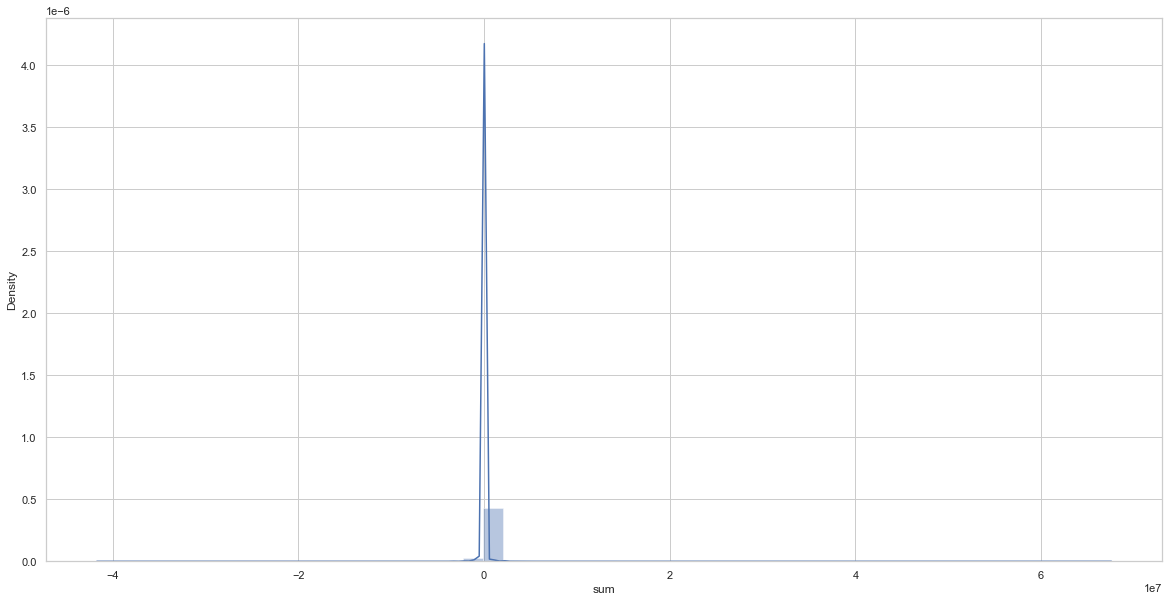

In [29]:
sns.distplot(df_joined['sum'])
plt.show()

#### Amount of transactions by code amd type descriptions

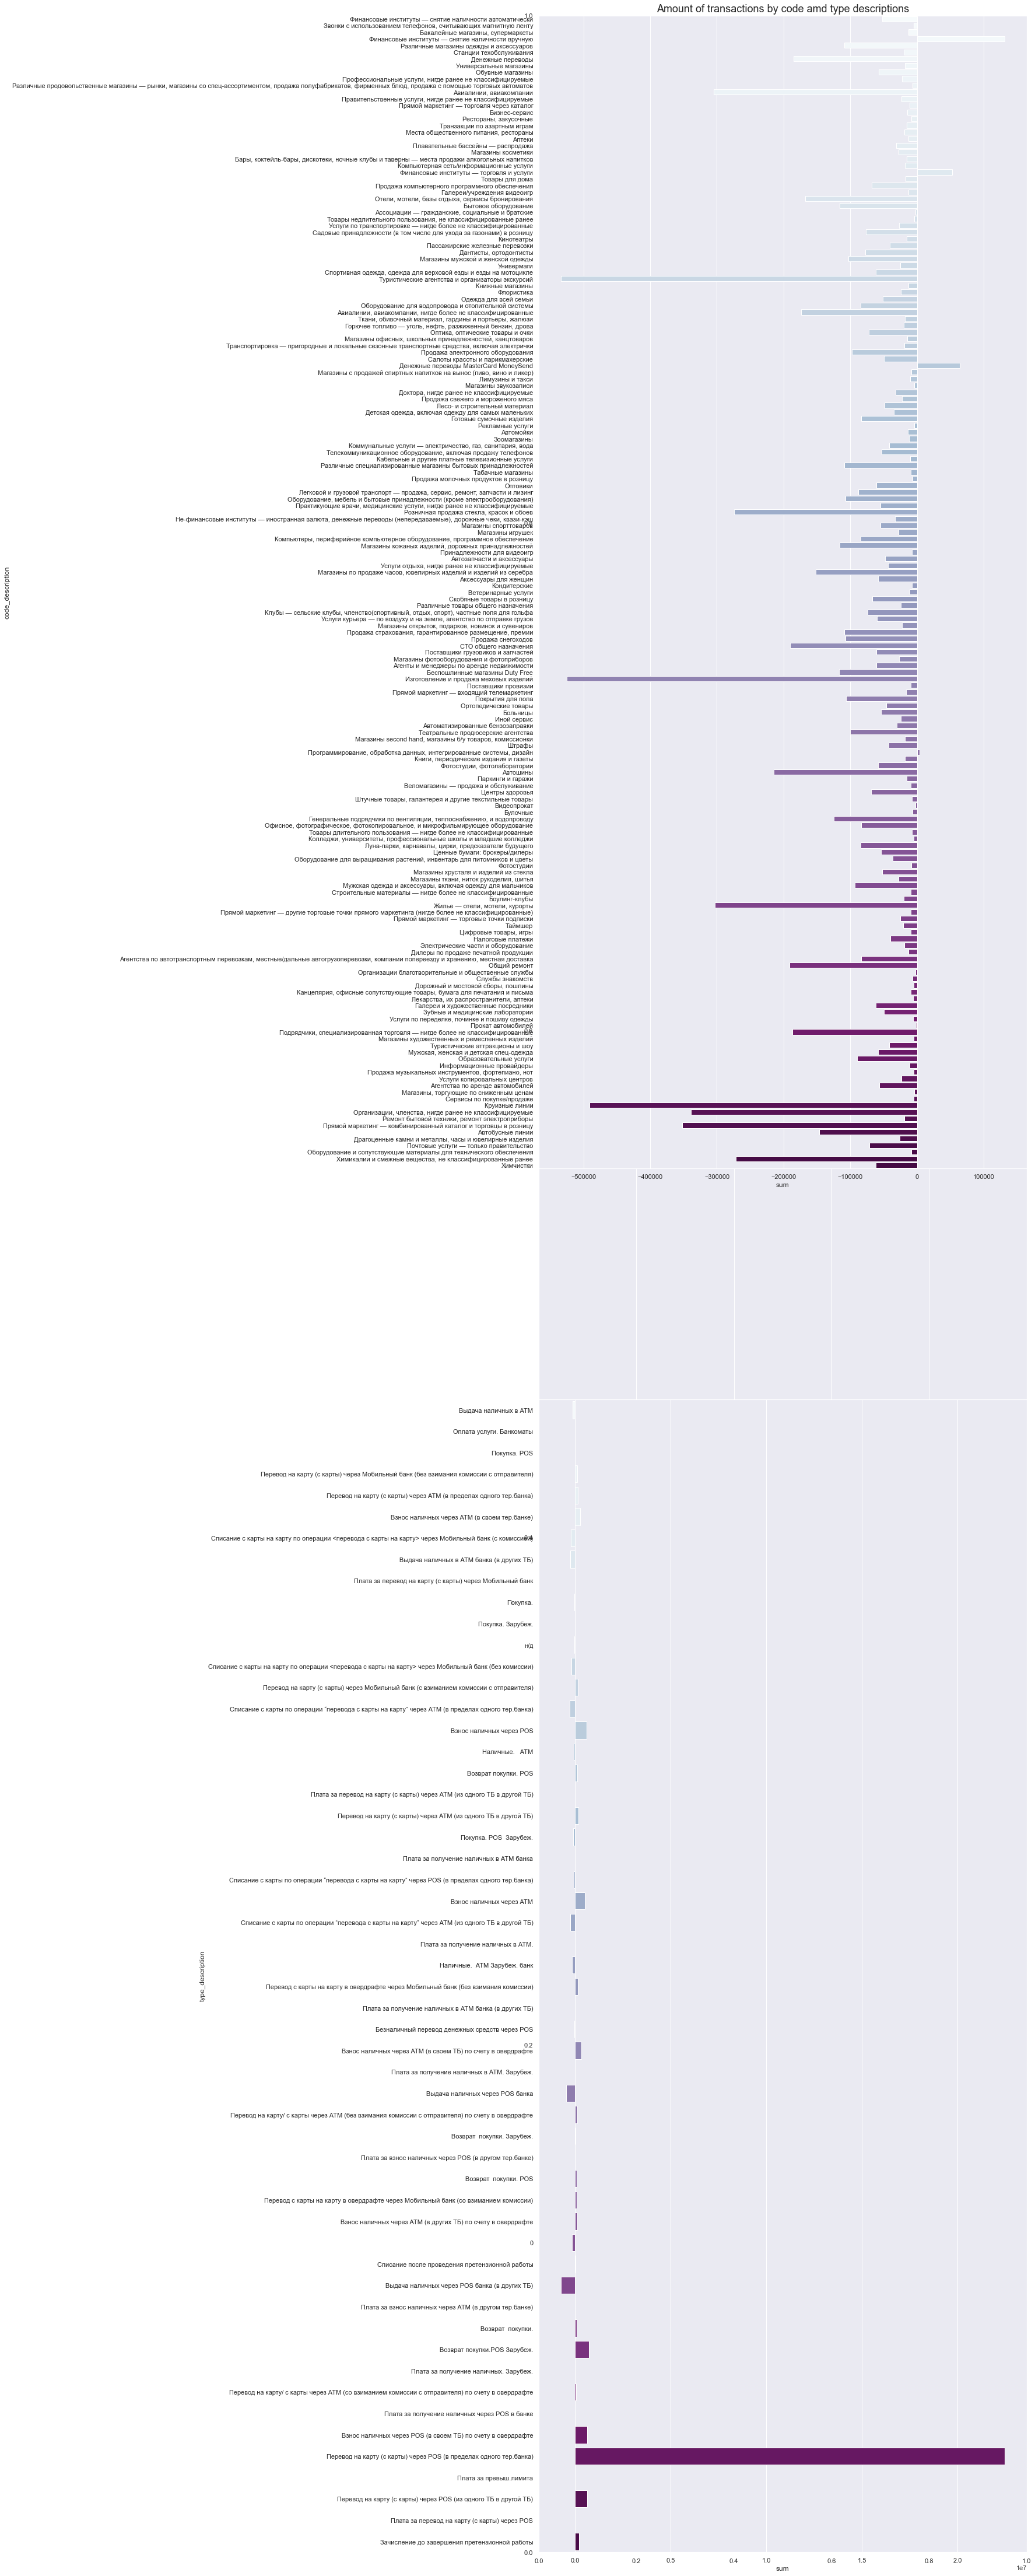

In [218]:
fig = plt.figure(figsize=(15, 80))
plt.title('Amount of transactions by code amd type descriptions', size=18)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sns.barplot(data=df_joined, y='code_description', x='sum', ax= ax1, palette='BuPu', ci= None)
sns.barplot(data=df_joined, y='type_description', x='sum', ax= ax2, palette='BuPu', ci= None)

plt.show()

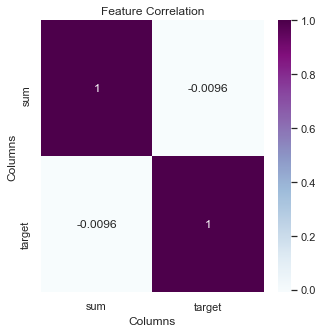

In [29]:
# correlation between gender and amounts of transactions
fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(df_joined.corr(), annot=True, ax=ax, cmap="BuPu").set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

Graph of Frequency of TOP 20 Type of transactions. As we can see from the graph, Покупка POS and выдача наличных в ATM are most popular ones.

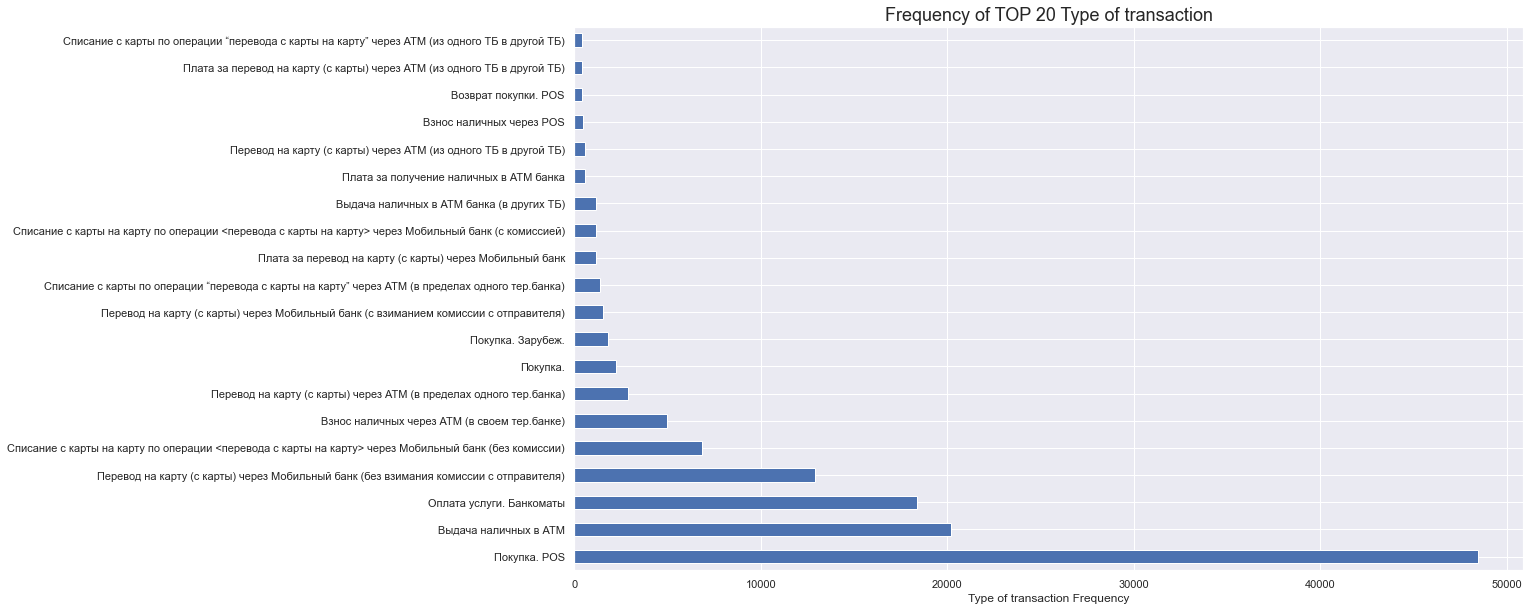

In [224]:
plt.figure(figsize=(17,10))
df.type_description.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Type of transaction Frequency')
plt.title("Frequency of TOP 20 Type of transaction",fontsize=18)
plt.show()

Graph of Frequency of TOP 20 Code of transactions. As we can see from the graph, Финансовые институты — снятие наличности aвтоматически and Финансовые институты — снятие наличности вручную are most popular ones.

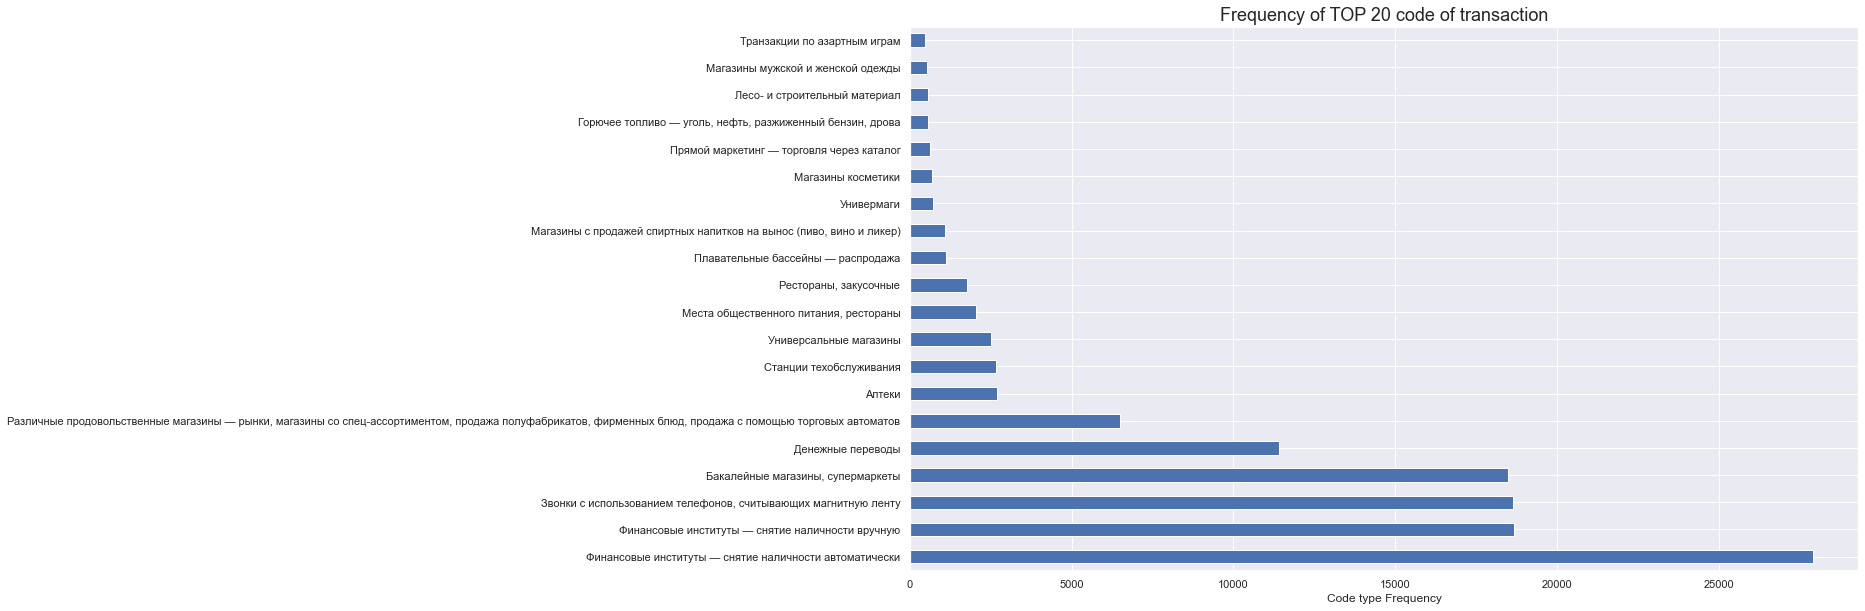

In [233]:
plt.figure(figsize=(17,10))
df.code_description.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('Code type Frequency')
plt.title("Frequency of TOP 20 code of transaction",fontsize=18)
plt.show()

### Feature engineering

In this part we will make our data ready for model training

In [213]:
# Identifying feature columns
features = df_joined.columns[1:]
features

Index(['datetime', 'code', 'type', 'sum', 'code_description',
       'type_description', 'target', 'day', 'hour', 'minute', 'second'],
      dtype='object')

We have codes and types descriptions, but we cannot use it just like that, because they are categorical features. So, we will just drop them, because encoding will slightly affect on the modeling results

In [223]:
df_joined.drop('code_description', axis='columns', inplace=True)

/Users/tomiriszhaksylyk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [224]:
df_joined.drop('type_description', axis='columns', inplace=True)

In [220]:
df_joined.drop('datetime', axis='columns', inplace=True)

/Users/tomiriszhaksylyk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [221]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91826 entries, 0 to 91825
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         91826 non-null  object 
 1   code              91826 non-null  float64
 2   type              91826 non-null  float64
 3   sum               91826 non-null  float64
 4   code_description  91826 non-null  object 
 5   type_description  91826 non-null  object 
 6   target            91826 non-null  float64
 7   day               91826 non-null  float64
 8   hour              91826 non-null  int64  
 9   minute            91826 non-null  int64  
 10  second            91826 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 7.7+ MB


In [215]:
df_joined["code"]=df_joined["code"].astype(str).astype(float)

<ipython-input-215-506d2bfbacdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined["code"]=df_joined["code"].astype(str).astype(float)


In [216]:
df_joined["type"]=df_joined["type"].astype(str).astype(float)

<ipython-input-216-5e7da15217b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined["type"]=df_joined["type"].astype(str).astype(float)


In [217]:
df_joined["day"]=df_joined["day"].astype(str).astype(float)

<ipython-input-217-47d312882267>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined["day"]=df_joined["day"].astype(str).astype(float)


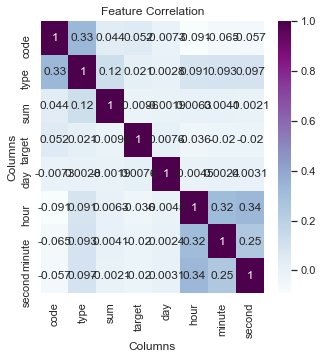

In [218]:
# correlation between gender and amounts of transactions
fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(df_joined.corr(), annot=True, ax=ax, cmap="BuPu").set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

Feature scaling - standardizing the data

In [225]:
# Standardize the data to all be the same unit

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_joined.drop('target', axis=1))

# Transforming the data
scaled_features = scaler.transform(df_joined.drop('target', axis=1))
scaled_features

array([[ 1.57323554,  0.6884737 , -0.23501079, ..., -0.90881082,
         0.37472087, -0.60163163],
       [-1.05552774,  0.6884737 , -0.23501079, ...,  0.21476921,
         0.64118144,  1.0718874 ],
       [ 1.18343625, -1.29943102, -0.66192027, ..., -0.26676509,
         0.42801298, -0.75852403],
       ...,
       [-0.3783184 , -0.30796977, -0.62707051, ...,  1.49886068,
        -0.69112139,  1.64715957],
       [-1.56761722, -0.30796977, -0.67063271, ...,  0.21476921,
         1.7070237 , -0.65392909],
       [ 1.42623561, -0.1053596 , -0.62707051, ..., -1.87187942,
        -1.38391886, -1.38609367]])

In [226]:
# Use the scaler to create scaler dataframe
# This gives us a standardized version of our data

df_feat = pd.DataFrame(scaled_features, columns=df_joined.columns[:-1])
df_feat.head()

,client_id,code,type,sum,target,day,hour,minute
0,1.573236,0.688474,-0.235011,-0.874175,1.366990,-0.908811,0.374721,-0.601632
1,-1.055528,0.688474,-0.235011,-0.045326,-1.444331,0.214769,0.641181,1.071887
2,1.183436,-1.299431,-0.661920,0.021342,-0.706936,-0.266765,0.428013,-0.758524
3,-0.713832,-0.307970,-0.627071,0.024225,1.190322,-1.871879,-1.383919,-1.386094
4,1.166690,0.686813,1.969236,0.035822,1.382352,0.535792,0.054968,1.490267


In [227]:
df_joined=df_joined.drop_duplicates(subset=['client_id'])


In [228]:
df_joined.reset_index(drop=True, inplace=True)
df_joined

,client_id,code,type,sum,target,day,hour,minute,second
0,96372458,6011.0,2010.0,-561478.94,0.0,421.0,6,33,15
1,21717441,6011.0,2010.0,-44918.32,0.0,55.0,13,38,47
2,85302434,4814.0,1030.0,-3368.87,0.0,151.0,10,34,12
3,31421357,5411.0,1110.0,-1572.14,0.0,398.0,0,0,0
4,84826852,6010.0,7070.0,5654.99,1.0,423.0,15,27,55
...,...,...,...,...,...,...,...,...,...
5995,4415650,6011.0,2010.0,-76361.14,1.0,453.0,15,14,43
5996,82133712,6011.0,2010.0,-17967.33,1.0,424.0,13,23,10
5997,12289409,6011.0,2010.0,-132509.03,0.0,108.0,11,13,33
5998,71829751,6011.0,2010.0,-44918.32,0.0,72.0,14,50,37


In [229]:
dummy_codes = pd.get_dummies(df_joined['code'])
dummy_types = pd.get_dummies(df_joined['type'])

In [165]:
dummy_codes

,1711.0,3000.0,4111.0,4112.0,4121.0,4214.0,4511.0,4722.0,4789.0,4812.0,...,8011.0,8021.0,8043.0,8062.0,8071.0,8099.0,8641.0,8999.0,9222.0,9399.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
df_joined= df_joined.join(dummy_codes)
df_joined

,client_id,code,type,sum,target,day,hour,minute,second,1711.0,...,8011.0,8021.0,8043.0,8062.0,8071.0,8099.0,8641.0,8999.0,9222.0,9399.0
0,96372458,6011.0,2010.0,-561478.94,0.0,421.0,6,33,15,0,...,0,0,0,0,0,0,0,0,0,0
1,21717441,6011.0,2010.0,-44918.32,0.0,55.0,13,38,47,0,...,0,0,0,0,0,0,0,0,0,0
2,85302434,4814.0,1030.0,-3368.87,0.0,151.0,10,34,12,0,...,0,0,0,0,0,0,0,0,0,0
3,31421357,5411.0,1110.0,-1572.14,0.0,398.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,84826852,6010.0,7070.0,5654.99,1.0,423.0,15,27,55,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4415650,6011.0,2010.0,-76361.14,1.0,453.0,15,14,43,0,...,0,0,0,0,0,0,0,0,0,0
5996,82133712,6011.0,2010.0,-17967.33,1.0,424.0,13,23,10,0,...,0,0,0,0,0,0,0,0,0,0
5997,12289409,6011.0,2010.0,-132509.03,0.0,108.0,11,13,33,0,...,0,0,0,0,0,0,0,0,0,0
5998,71829751,6011.0,2010.0,-44918.32,0.0,72.0,14,50,37,0,...,0,0,0,0,0,0,0,0,0,0


In [231]:
df_joined = df_joined.join(dummy_types, lsuffix='_type')
df_joined

,client_id,code,type,sum,target,day,hour,minute,second,1711.0,...,7011.0,7014.0,7020.0,7021.0,7030.0,7031.0,7034.0,7070.0,7071.0,7074.0
0,96372458,6011.0,2010.0,-561478.94,0.0,421.0,6,33,15,0,...,0,0,0,0,0,0,0,0,0,0
1,21717441,6011.0,2010.0,-44918.32,0.0,55.0,13,38,47,0,...,0,0,0,0,0,0,0,0,0,0
2,85302434,4814.0,1030.0,-3368.87,0.0,151.0,10,34,12,0,...,0,0,0,0,0,0,0,0,0,0
3,31421357,5411.0,1110.0,-1572.14,0.0,398.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,84826852,6010.0,7070.0,5654.99,1.0,423.0,15,27,55,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4415650,6011.0,2010.0,-76361.14,1.0,453.0,15,14,43,0,...,0,0,0,0,0,0,0,0,0,0
5996,82133712,6011.0,2010.0,-17967.33,1.0,424.0,13,23,10,0,...,0,0,0,0,0,0,0,0,0,0
5997,12289409,6011.0,2010.0,-132509.03,0.0,108.0,11,13,33,0,...,0,0,0,0,0,0,0,0,0,0
5998,71829751,6011.0,2010.0,-44918.32,0.0,72.0,14,50,37,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = df_joined
y = df_joined['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Supervised learning
### Modeling

#### KNN

In [233]:
# Training and Predictions

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
pred

array([0., 0., 0., ..., 1., 0., 0.])

In [234]:
# Evaluating the algorithm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print (confusion_matrix(y_test, pred))
print (classification_report(y_test, pred))
print ('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

[[601 401]
 [500 298]]
              precision    recall  f1-score   support

         0.0       0.55      0.60      0.57      1002
         1.0       0.43      0.37      0.40       798

    accuracy                           0.50      1800
   macro avg       0.49      0.49      0.48      1800
weighted avg       0.49      0.50      0.49      1800

Accuracy Score: 0.5238888888888888


The algorithm doesn't do a better prediction than a random draw would. Let's find the k with the lowest error rate through iterations.

The intuition behind choosing the best value of k is beyond the scope of this article, but we should know that we can determine the optimum value of k when we get the highest test score for that value. For that, we can evaluate the training and testing scores for up to 40 nearest neighbors:

In [235]:
error_rate = []

for i in range(1,40): # Checking every possible k value between 1-40
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
error_rate

[0.4861111111111111,
 0.47055555555555556,
 0.5005555555555555,
 0.47,
 0.49833333333333335,
 0.47888888888888886,
 0.49666666666666665,
 0.4761111111111111,
 0.4888888888888889,
 0.4822222222222222,
 0.4905555555555556,
 0.47833333333333333,
 0.49666666666666665,
 0.4872222222222222,
 0.4961111111111111,
 0.4905555555555556,
 0.49722222222222223,
 0.49333333333333335,
 0.495,
 0.4822222222222222,
 0.48277777777777775,
 0.4761111111111111,
 0.4761111111111111,
 0.47555555555555556,
 0.4816666666666667,
 0.4761111111111111,
 0.4811111111111111,
 0.4761111111111111,
 0.48,
 0.46944444444444444,
 0.48,
 0.4761111111111111,
 0.4761111111111111,
 0.475,
 0.48277777777777775,
 0.47555555555555556,
 0.48277777777777775,
 0.4716666666666667,
 0.4772222222222222]

The error rate is what we want to minimize, so we want to know the k that gives the smallest error rate. Let's create a visual representation to make life easier.

Text(0, 0.5, 'Mean error rate')

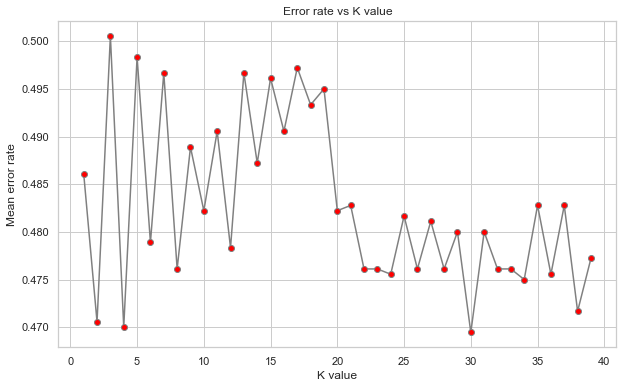

In [236]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='grey', marker='o', markerfacecolor='red')
plt.title('Error rate vs K value')
plt.xlabel('K value')
plt.ylabel('Mean error rate')

0.42 is a very high error rate, but it is the best we're able to find. Let's now run the model again with k=4 again instead of k=3.

A confusion matrix helps us gain an insight into how correct our predictions were and how they hold up against the actual values.

In [239]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print ('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

[[800 202]
 [644 154]]
              precision    recall  f1-score   support

         0.0       0.55      0.80      0.65      1002
         1.0       0.43      0.19      0.27       798

    accuracy                           0.53      1800
   macro avg       0.49      0.50      0.46      1800
weighted avg       0.50      0.53      0.48      1800

Accuracy Score: 0.53


We were able to classify a couple of more points correctly, but in general, an accuracy score of 0.6 is not good. It looks like we'd need more data (more features or larger dataset) to build a more robust model.

#### Model Analyzing
For any machine learning model, we know that achieving a ‘good fit’ on the model is extremely crucial. This involves achieving the balance between underfitting and overfitting, or in other words, a tradeoff between bias and variance. A useful tool when predicting the probability of a binary outcome is the ROC curve. It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate. The area with the curve and the axes as the boundaries is called the Area Under Curve (AUC). It is this area which is considered as a metric of a good model. With this metric ranging from 0 to 1, we should aim for a high value of AUC. Models with a high AUC are called as models with good skill.  

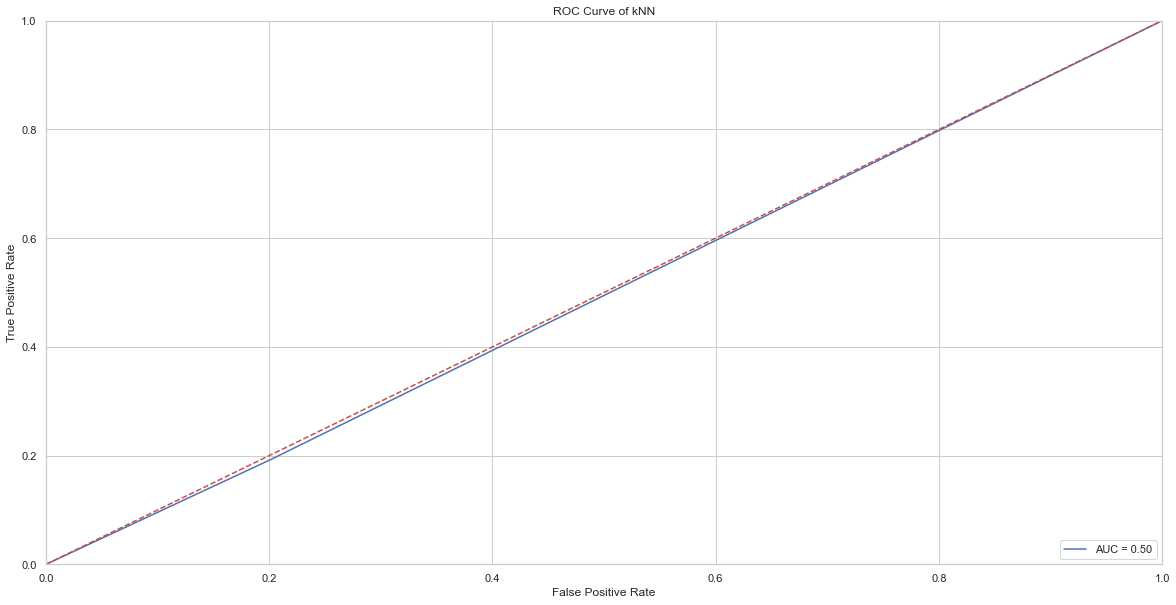

In [240]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

Precision Recall curve is a direct representation of the precision(y-axis) and the recall(x-axis)

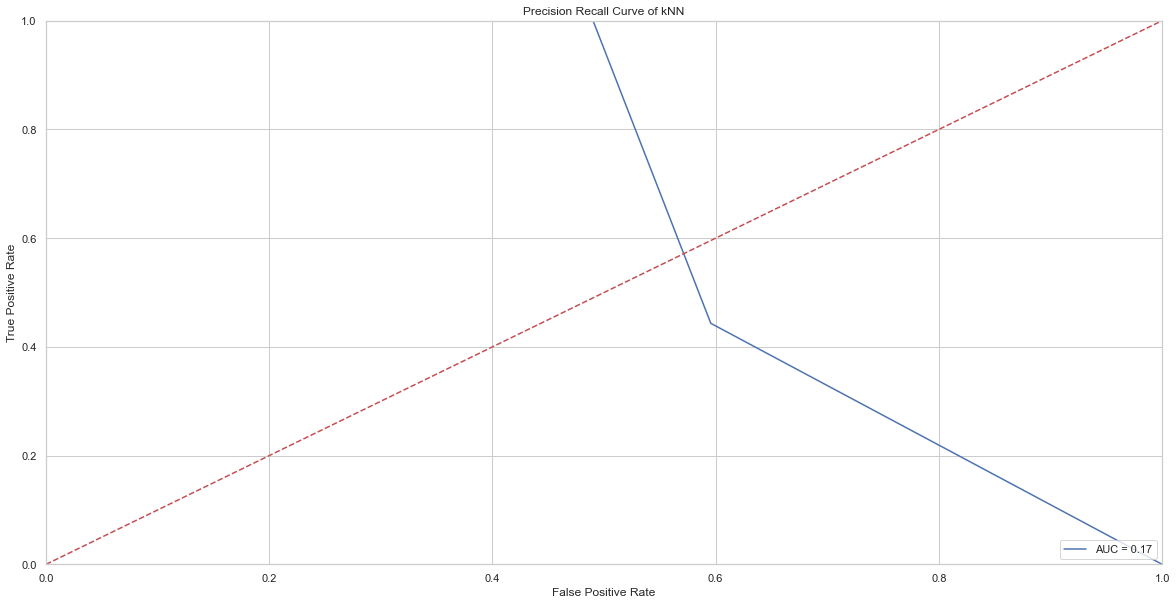

In [107]:
fpr, tpr, threshold = precision_recall_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Precision Recall Curve of kNN')
plt.show()

### Random Forest

Let's try the Random Forest algorithm instead. We have already scaled data and split into train and test sets.


In [241]:
# Training the algorithm

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=101)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [242]:
# Evaluating the algorithm

print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))
print ('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

[[1002    0]
 [   0  798]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1002
         1.0       1.00      1.00      1.00       798

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

Accuracy Score: 1.0


Nothing better than a random draw. Let's instead use grid search to find the best parameter values. Parameter tuning is the process to selecting the values for a model’s parameters that maximize the accuracy of the model.

In [47]:
# Grid search

grid_param = {  
    'n_estimators': [80, 100, 120],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [10, 30,50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [3,9,20],
    'min_samples_leaf': [1, 2, 4]
    }

gs = GridSearchCV(estimator=forest,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=101),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [30, 50],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 9, 20],
                         'n_estimators': [100, 120]},
             scoring='accuracy')

In [48]:
print(gs.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 120}


In [243]:
# Training the tuned algorithm

forest_tuned = RandomForestClassifier(n_estimators=120,
                                      criterion= 'gini',
                                      bootstrap= False,
                                      max_depth= 30,
                                      max_features= 'auto',
                                      min_samples_split= 20,
                                      min_samples_leaf= 1,
                                      random_state=101)
forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

In [244]:
# Evaluating the tuned algorithm

print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))
print ('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

[[1002    0]
 [   1  797]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1002
         1.0       1.00      1.00      1.00       798

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

Accuracy Score: 0.9994444444444445


Slightly better than previously, but still not noticably different from a random draw.

In [245]:
# Identifying feature columns
features = df_joined.columns[1:]
features

Index([  'code',   'type',    'sum', 'target',    'day',   'hour', 'minute',
       'second',   1711.0,   3000.0,
       ...
       '7011.0',   7014.0,   7020.0,   7021.0,   7030.0,   7031.0,   7034.0,
         7070.0,   7071.0,   7074.0],
      dtype='object', length=161)

IndexError: index 161 is out of bounds for axis 0 with size 161

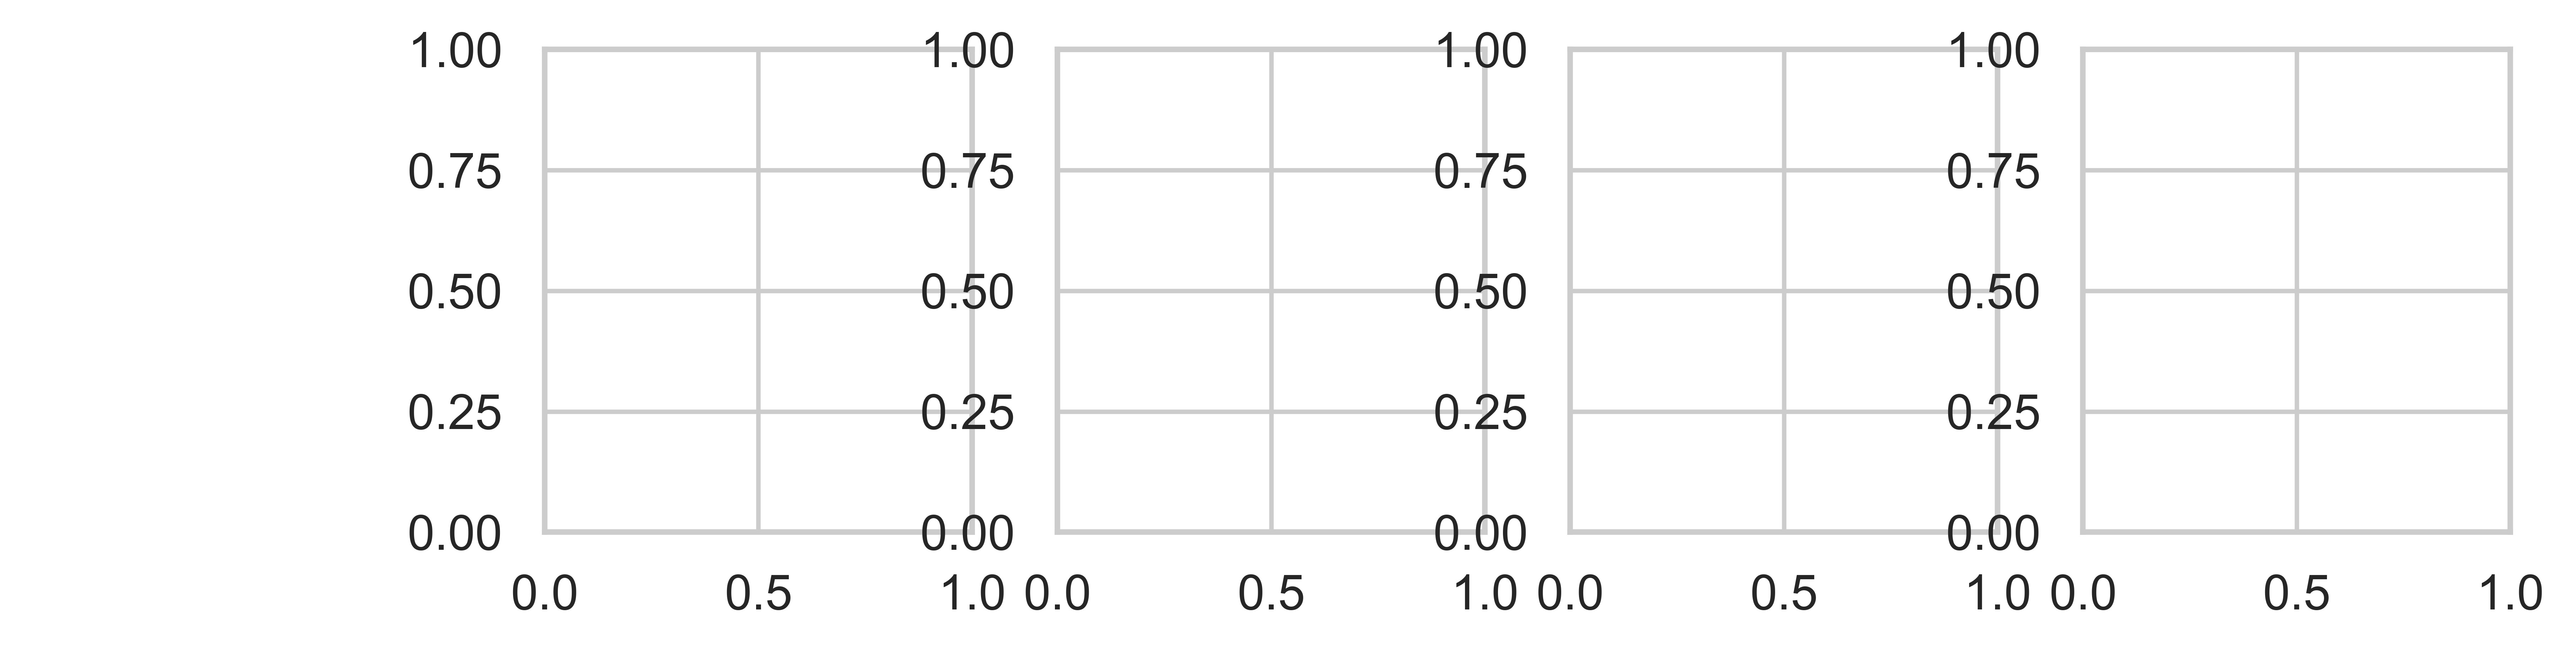

In [246]:
# This may not the best way to view each estimator as it is small

fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(forest_tuned.estimators_[index],
                   feature_names = features, 
                   class_names=['0','1'],
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')


ROC Curve for Random Forest

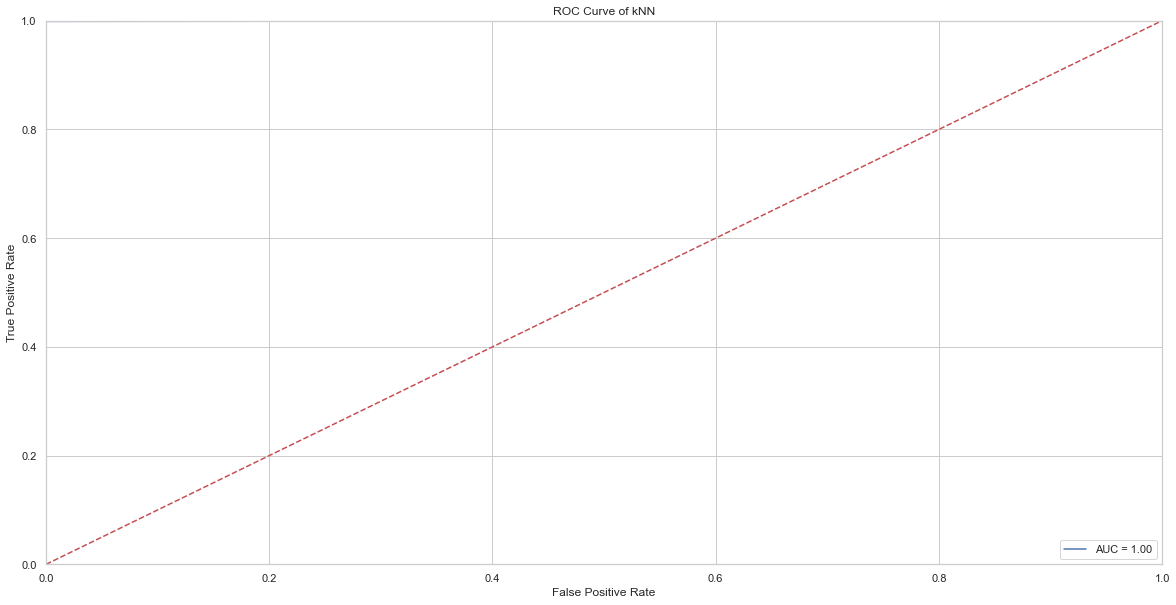

In [247]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

Precision Recall Curve of Random Forest

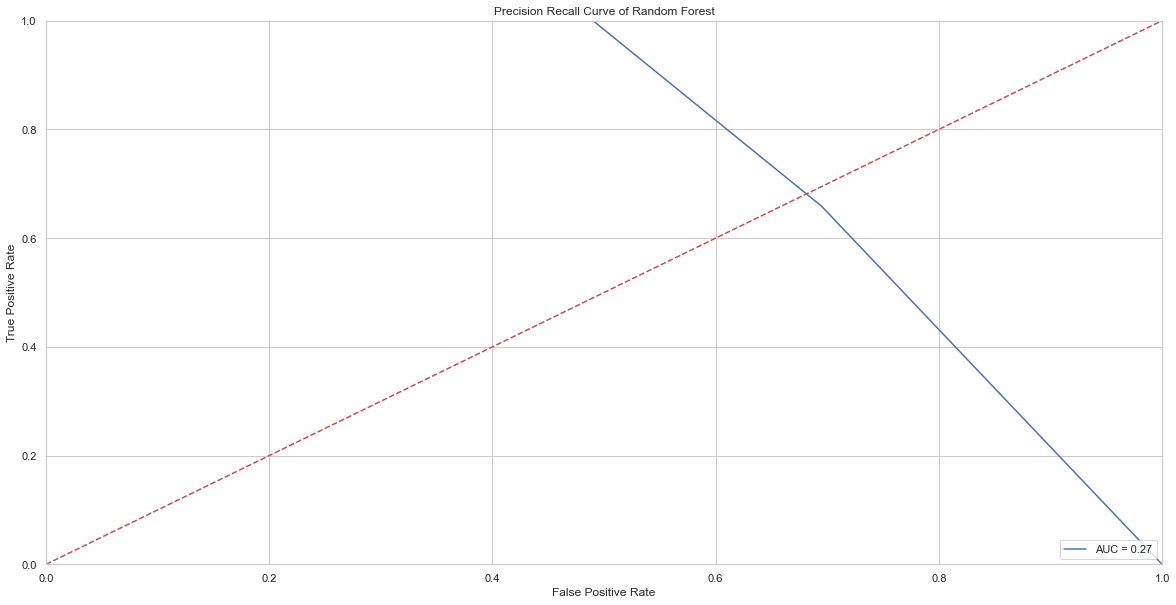

In [104]:
fpr, tpr, threshold = precision_recall_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Precision Recall Curve of Random Forest')
plt.show()

#### SVM

In [48]:
from sklearn.svm import SVC

In [49]:
# Training the algorithm
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [53]:
# Evaluating the algorithm

print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))
print ('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

[[9224 4822]
 [7628 5874]]
              precision    recall  f1-score   support

         0.0       0.55      0.66      0.60     14046
         1.0       0.55      0.44      0.49     13502

    accuracy                           0.55     27548
   macro avg       0.55      0.55      0.54     27548
weighted avg       0.55      0.55      0.54     27548

Accuracy Score: 0.5480615652678961


Let's train the algorithm again, using the information from the grid search.

In [91]:
# Grid search

# "C" controls the cost of misclassification on the training data. 
# A large C-value gives you low bias and high variance. Low bias causes you penalize the cost of misclassification a lot.

# Small "gamma" means a Gaussian of a large variance. Large gamma leads to high bias and low variance in the model. 

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

gs = GridSearchCV(SVC(), param_grid, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .................................C=0.1, gamma=1; total time=13.0min
[CV 2/5] END .................................C=0.1, gamma=1; total time= 3.8min
[CV 3/5] END .................................C=0.1, gamma=1; total time= 3.6min
[CV 4/5] END .................................C=0.1, gamma=1; total time= 3.6min
[CV 5/5] END .................................C=0.1, gamma=1; total time= 3.7min
[CV 1/5] END ...............................C=0.1, gamma=0.1; total time= 3.8min
[CV 2/5] END ...............................C=0.1, gamma=0.1; total time= 5.4min
[CV 3/5] END ...............................C=0.1, gamma=0.1; total time= 4.2min
[CV 4/5] END ...............................C=0.1, gamma=0.1; total time= 5.6min
[CV 5/5] END ...............................C=0.1, gamma=0.1; total time= 3.8min
[CV 1/5] END ..............................C=0.1, gamma=0.01; total time= 4.5min
[CV 2/5] END ..............................C=0.

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [93]:
print(gs.best_params_)

{'C': 1000, 'gamma': 1}


In [123]:
# Training the tuned algorithm

svm_tuned = SVC(C = 1000, gamma = 1)
svm_tuned.fit(X_train, y_train)
y_pred = svm_tuned.predict(X_test)

In [124]:
# Evaluating the algorithm

print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test, y_pred))
print ('Accuracy Score: ' + str(accuracy_score(y_test, y_pred)))

[[9259 4787]
 [6987 6515]]
              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61     14046
         1.0       0.58      0.48      0.53     13502

    accuracy                           0.57     27548
   macro avg       0.57      0.57      0.57     27548
weighted avg       0.57      0.57      0.57     27548

Accuracy Score: 0.5726005517641934


ROC Curve of SVM

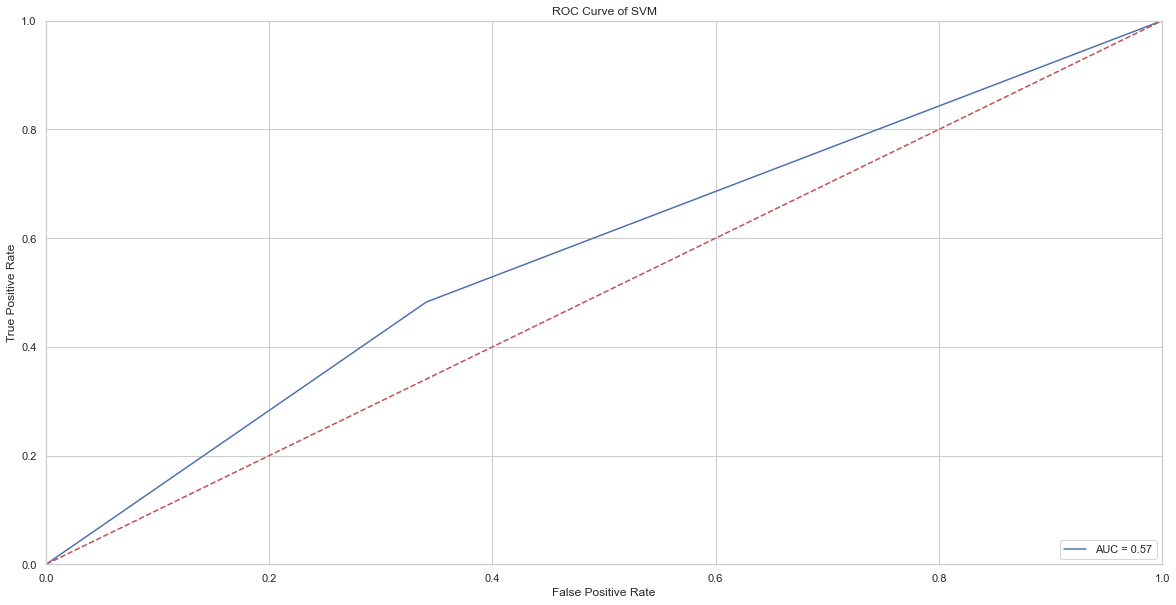

In [125]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of SVM')
plt.show()

Precision Recall Curve of SVM

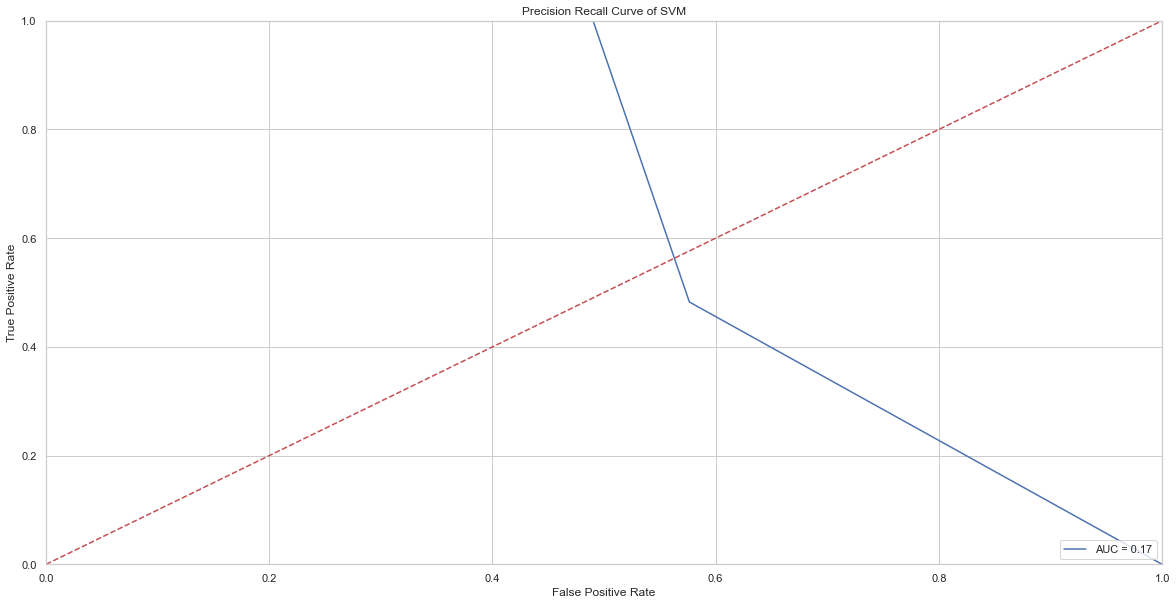

In [126]:
fpr, tpr, threshold = precision_recall_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Precision Recall Curve of SVM')
plt.show()

### Deccision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

Let's create a Decision Tree Model using Scikit-learn.


In [42]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

Let's estimate, how accurately the classifier or model can predict the type of cultivars.
Accuracy can be computed by comparing actual test set values and predicted values.

In [44]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7584942645564107


Well, you got a classification rate of 75.85%, considered as good accuracy. You can improve this accuracy by tuning the parameters in the Decision Tree Algorithm.

In Scikit-learn, optimization of decision tree classifier performed by only pre-pruning. Maximum depth of the tree can be used as a control variable for pre-pruning. In the following the example, we plot a decision tree on the same data with max_depth=100. Other than pre-pruning parameters, we also try other attribute selection measure such as entropy.

In [111]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=100)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7729417743574851


##### ROC Curve of Deccision Tree

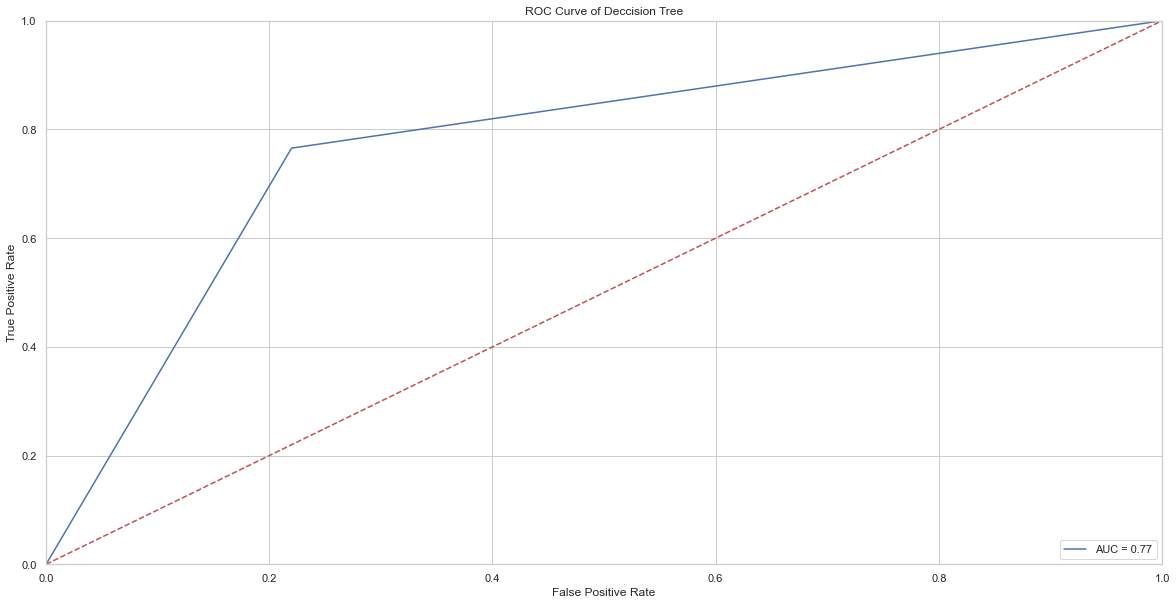

In [113]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Deccision Tree')
plt.show()

##### Precision Recall Curve of Deccision Tree

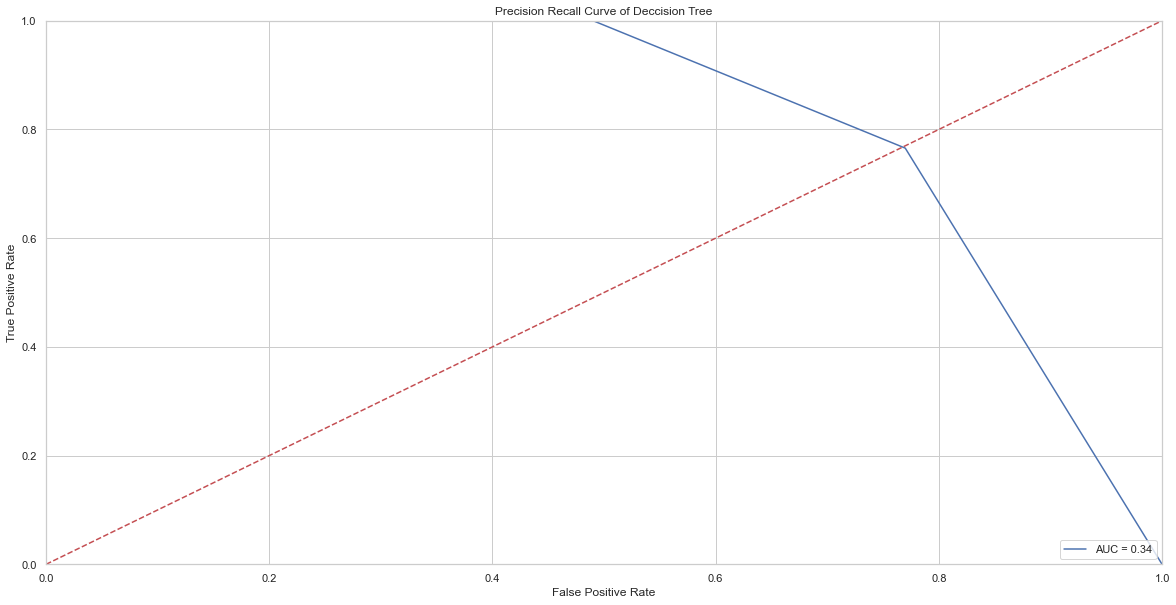

In [114]:
fpr, tpr, threshold = precision_recall_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Precision Recall Curve of Deccision Tree')
plt.show()

## Conclusion

Neither KNN, Random Forest, Decision Tree nor the SVM algorithm are very useful in terms of predicting the gender of the customer based on the features Sum, Coded and Type. This indicates that the data does not have prediction capability. This doesn't come as a huge surprise, as we could already see in the EDA that there was little that suggested any major differences between the two genders when it came to these variables. 

This work proposes a method that predicts users’ gender based on their transactions history information. This dataset is probably best suited for unsupervised ML techniques, but I was curious to see whether there are attributes that can help predict whether a customer is male or female. It's a small dataset (both in terms of features and number of customers), however I think this notebook gives a useful introduction to applying ML algorithms such as Random Forest, SVM, Decision Tree and KNN.

The best accuracy was with Deccision Tree model is 0.77

A high error rate indicates that the model is underfitting and has high bias. The model is not sufficiently complex, so it's simply not capable of representing the relationship between y and the input features. To combat this we could try increasing the number of input features.